# Homework 3: Helen Rhee

Collaborators: Alex Cui

In [1]:
!conda install mkl-service -y

Solving environment: done

# All requested packages already installed.



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interact, interactive
import itertools
import hashlib
from scipy.stats import poisson, norm, gamma
#!pip install pymc3
import statsmodels.api as sm
import timeit
  
sns.set(style="dark")
plt.style.use("ggplot")

try:
    from pymc3 import *
    import pymc3 as pm
except:
    ! pip install pymc3
    from pymc3 import *
    import pymc3 as pm

import arviz as az

# 2. Image Denoising with Gibbs Sampling

In [3]:
import pickle

with open('X.pkl', 'rb') as f:
    X = pickle.load(f)

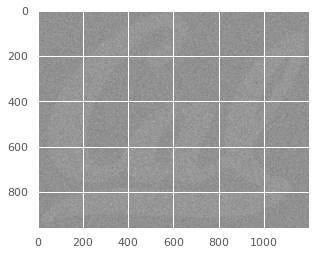

In [4]:
plt.imshow(X, cmap=cm.Greys_r);

**B) Done on paper**

**C) Done on paper**

**D)** Implement the Gibbs sampler from Part (c) with a = 250, b = 62.5, and τ = 0.01. 
Run your code for T = 1 iteration:
    i.e. update each coordinate exactly once 
Visualize the resulting image Z(1). 
Time your code and estimate how long it would take to compute Z(100)

In [5]:
#produce an array of neighboring elements of X[i][j], 0-indexed
def find_neighbors(i, j, X):
    results = []
    max_row = X.shape[0] - 1
    max_col = X.shape[1] - 1
    
    #check top row
    if i == 0:
        results += [X[1][j]]

    #check bottom row
    elif i == max_row:
        results += [X[i - 1][j]]
        
    else:
        results += [X[i + 1][j]]
        results += [X[i - 1][j]]
    
    #check left col
    if j == 0:
        results += [X[i][1]]
    
    #check right col
    elif j == max_col:
        results += [X[i][j - 1]]
    
    else:
        results += [X[i][j + 1]]
        results += [X[i][j - 1]]
    
    return np.array(results)
        

In [88]:
%%timeit

# Sample Z(1)
a = 250
b = 62.5
t = 0.01

T = 1
Z = X
for _ in range(T):
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            sigma = np.sqrt(1 / (a + t))
            mu = (t * X[i][j] + b * sum(find_neighbors(i, j, Z))) / (a + t)
            Z[i][j] = np.random.randn() * sigma + mu

7.64 s ± 89.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


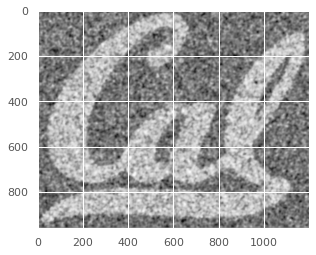

In [93]:
plt.imshow(Z, cmap=cm.Greys_r);

It took around 7.6 seconds to compute Z(1), so it would take around 760 seconds (~12 minutes) to compute Z(100).

**Part e)** Why does blocked Gibbs sampling work?
Specifically, define two subsets of the pixels 
- Ieven = {(i, j) : i + j is even}
- Iodd = {(i, j) : i + j is odd}

**Answer** Updating half the variables Z(I even) and then Z(I odd) at once is justified because they are mutually exclusive sets, and will not interfere with each other's processes. 
Odd numbers are produced when odd + even, and even numbers are either odd + odd, or even + even.
Because of this property, given a specified row, the alternating elements of that row will belong to either I even or I odd.

**Part f)** Implement Gibbs sampler from above for T = 100 iterations. 
- Compute entire n x m matrix S using matrix operations on Z. 
- pad the matrix Z with a border of zeros using Z bar = np.pad(Z, 1)
- Use slicing on the (n+ 2)×(m + 2) matrix Z bar to compute S

In [95]:
Z_bar = np.pad(Z, 1)


,0,1,2,3,4,5,6,7,8,9,...,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.019408,0.031289,0.045898,0.062953,0.062603,0.070684,0.058738,0.048454,0.029337,...,0.010428,-0.005689,-0.020108,-0.029076,-0.041146,-0.039425,-0.031523,-0.024768,-0.015336,0.0
2,0.0,0.038431,0.058801,0.096927,0.097493,0.109711,0.107626,0.093869,0.075545,0.040424,...,-0.017904,-0.033894,-0.063557,-0.085590,-0.104514,-0.105614,-0.088509,-0.063190,-0.032335,0.0
3,0.0,0.044200,0.069095,0.109315,0.116459,0.130895,0.123084,0.094789,0.050042,-0.008546,...,-0.090033,-0.121425,-0.163321,-0.184967,-0.201503,-0.204026,-0.177109,-0.122489,-0.059171,0.0
4,0.0,0.047038,0.073067,0.102606,0.110785,0.113265,0.098997,0.051328,-0.011234,-0.097080,...,-0.224449,-0.267652,-0.304477,-0.328216,-0.339366,-0.319896,-0.281195,-0.208441,-0.105327,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,0.0,-0.101616,-0.181883,-0.258425,-0.338896,-0.423594,-0.511346,-0.594647,-0.680562,-0.764971,...,-0.427532,-0.411256,-0.360552,-0.314063,-0.242123,-0.176362,-0.117792,-0.054238,-0.028631,0.0
960,0.0,-0.068986,-0.122959,-0.177163,-0.235823,-0.299049,-0.371243,-0.438969,-0.515491,-0.579001,...,-0.328521,-0.317887,-0.292221,-0.252461,-0.201888,-0.140501,-0.090813,-0.052996,-0.020021,0.0
961,0.0,-0.038226,-0.076716,-0.115863,-0.151143,-0.188107,-0.238325,-0.290041,-0.339304,-0.389737,...,-0.220413,-0.208941,-0.196591,-0.174596,-0.140826,-0.110356,-0.071642,-0.036552,-0.020873,0.0
962,0.0,-0.015173,-0.048300,-0.058613,-0.073601,-0.102797,-0.120797,-0.147021,-0.169385,-0.194110,...,-0.110099,-0.108247,-0.101021,-0.086385,-0.073899,-0.060630,-0.035492,-0.017319,-0.008634,0.0


In [32]:
%%time

#Form I even and I odd
grid = np.meshgrid(np.arange(0, X.shape[1]), np.arange(0, X.shape[0]))
even = (grid[0] + grid[1]) % 2 == 0
odd = (grid[0] + grid[1]) % 2 == 1

#Initialize Z(0) and pad I odd & I even
Z = np.pad(X, 1)
padded_even = np.pad(even, 1)
padded_odd = np.pad(odd, 1)

#Hyperparameters
T = 100
S = 0
a = 250
b = 62.5
t = .01

row = X.shape[0] 
col = X.shape[1] 

#Loop over all T for blocked Gibbs sampling
for _ in range(T):
    
        #Even
        #Compute S matrix
        S = Z[2:, 1:-1] + Z[:-2, 1:-1] + Z[1:-1, 2:] + Z[1:-1, :-2]
      
        #Sampling
        mu = ((t * X) + (b * S)) / (a + t)
        sigma = np.sqrt(1 / (a + t))
        f = mu + np.random.randn(row, col) * sigma
        Z[padded_even] = np.pad(f * even, 1)[padded_even]
        
        #Odd
        #Compute S matrix
        S = Z[2:, 1:-1] + Z[:-2, 1:-1] + Z[1:-1, 2:] + Z[1:-1, :-2]
       
        #Sampling
        mu = ((t * X) + (b * S)) / (a + t)
        sigma = np.sqrt(1 / (a + t))
        d = mu + np.random.randn(row, col) * sigma
        Z[padded_odd] = np.pad(f * odd, 1)[padded_odd]
    
Z

CPU times: user 13.6 s, sys: 16.3 ms, total: 13.6 s
Wall time: 13.6 s


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.0316306 , -0.11782242, ..., -0.04156822,
         0.01418591,  0.        ],
       [ 0.        , -0.02197141,  0.06157157, ..., -0.17947989,
        -0.16175682,  0.        ],
       ...,
       [ 0.        ,  0.04242278, -0.15039068, ...,  0.01834068,
        -0.06458668,  0.        ],
       [ 0.        , -0.09487766,  0.00792823, ..., -0.10100656,
        -0.06427404,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

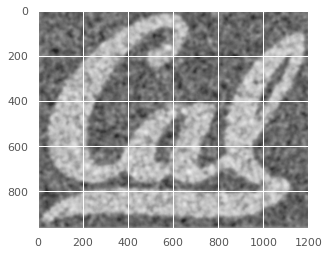

In [33]:
plt.imshow(Z, cmap=cm.Greys_r);

# 3. Bayesian GLM

Try to predict how much Democrats won by "house_dem20_margin" using current officer's ideology score ("govtrack_ideology") & (house_dem18_margin). NO INTERCEPT. 

In [5]:
elections = pd.read_csv('us_elections.csv')
elections

,district,trump16_margin,obama12_margin,house_dem18_margin,house_dem_avg_margin,rpt,incumbent_party,safety,house_dem20_margin,house20_winner,govtrack_ideology,last_name
0,AK-AL,0.152,-0.141,-0.065848,-0.165514,0.51,R,Vulnerable,-0.264,Rep,0.576742,b'Young'
1,AL-1,0.294,-0.244,-0.263798,-0.642656,0.88,R,Safe,-0.360,Rep,0.768097,b'Byrne'
2,AL-2,0.319,-0.265,-0.229625,-0.233190,0.94,R,Safe,-0.307,Rep,0.554987,b'Roby'
3,AL-3,0.330,-0.255,-0.274989,-0.305166,0.76,R,Safe,-0.378,Rep,0.592498,b'Rogers'
4,AL-4,0.630,-0.508,-0.596457,-0.762051,0.91,R,Safe,-0.658,Rep,0.599342,b'Aderholt'
...,...,...,...,...,...,...,...,...,...,...,...,...
426,WI-8,0.176,-0.037,-0.274185,-0.237034,0.82,R,Safe,-0.308,Rep,0.706871,b'Gallagher'
427,WV-1,0.416,-0.267,-0.291503,-0.299911,0.91,R,Safe,-0.375,Rep,0.669251,b'McKinley'
428,WV-2,0.364,-0.220,-0.109833,-0.175190,0.97,R,Safe,-0.262,Rep,0.891064,b'Mooney'
429,WV-3,0.492,-0.322,-0.127468,-0.148480,0.93,R,Safe,-0.428,Rep,0.656066,b'Miller'


In [6]:
elections.iloc[430]

district                    WY-AL
trump16_margin              0.476
obama12_margin             -0.412
house_dem18_margin      -0.338195
house_dem_avg_margin    -0.380987
rpt                          0.93
incumbent_party                 R
safety                       Safe
house_dem20_margin         -0.441
house20_winner                Rep
govtrack_ideology        0.590955
last_name               b'Cheney'
Name: 430, dtype: object

**Part A)**
Use the documentation of PyMC3 to figure out how to choose a prior for a GLM, and then obtain 1000 samples from the posterior distribution for β.

Make three scatter plots showing the posterior samples for different values of sigma^2 = {1, 0.01, 10^−4}. 

- All three scatter plots should be plotted with the same axis range (for example, if one scatter plot has an x-axis that goes from -0.3 to 0.1, then all three of them should too).

In [7]:
#variance = 1
with pm.Model() as model:
    
    #define priors
    priors = {
        'Regressor': pm.Normal.dist(0, 1)    
    }
    
    #Formula: y ~ 0 + x1 + x2
    glm.GLM.from_formula('house_dem20_margin ~ 0 + govtrack_ideology + house_dem18_margin', elections, priors=priors)
    
    #sample
    trace = pm.sample(500, cores=1, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, house_dem18_margin, govtrack_ideology]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 7 seconds.


In [8]:
df_a1 = trace.posterior[["govtrack_ideology", "house_dem18_margin"]].to_dataframe()
df_a1

govtrack_ideology  house_dem18_margin
chain draw                                       
0     0             -0.173084            0.795869
      1             -0.164664            0.785970
      2             -0.136765            0.790972
      3             -0.127433            0.809964
      4             -0.150896            0.809129
...                       ...                 ...
1     495           -0.146225            0.793669
      496           -0.140323            0.820107
      497           -0.128109            0.813976
      498           -0.141333            0.839607
      499           -0.136032            0.767658

[1000 rows x 2 columns]

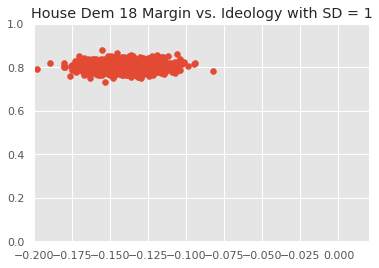

In [16]:
plt.scatter(df_a1["govtrack_ideology"], df_a1["house_dem18_margin"])
plt.xlim(-0.2, 0.02)
plt.ylim(0, 1)
plt.title("House Dem 18 Margin vs. Ideology with SD = 1");

In [10]:
#variance = 0.01
with pm.Model() as model:
    
    #define priors
    priors = {
        'Regressor': pm.Normal.dist(0, 0.1)    
    }
    
    #Formula: y ~ 0 + x1 + x2
    glm.GLM.from_formula('house_dem20_margin ~ 0 + govtrack_ideology + house_dem18_margin', elections, priors=priors)
    
    #sample
    trace = pm.sample(500, cores=1, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, house_dem18_margin, govtrack_ideology]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 7 seconds.


In [11]:
df_a2 = trace.posterior[["govtrack_ideology", "house_dem18_margin"]].to_dataframe()

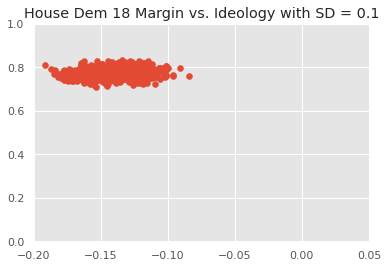

In [17]:
plt.scatter(df_a2["govtrack_ideology"], df_a2["house_dem18_margin"])
plt.xlim(-0.2, 0.05)
plt.ylim(0, 1)

plt.title("House Dem 18 Margin vs. Ideology with SD = 0.1");

In [13]:
#variance = 0.0001
with pm.Model() as model:
    
    #define priors
    priors = {
        'Regressor': pm.Normal.dist(0, 0.01)    
    }
    
    #Formula: y ~ 0 + x1 + x2
    glm.GLM.from_formula('house_dem20_margin ~ 0 + govtrack_ideology + house_dem18_margin', elections, priors=priors)
    
    #sample
    trace = pm.sample(500, cores=1, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, house_dem18_margin, govtrack_ideology]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 7 seconds.


In [14]:
df_a3 = trace.posterior[["govtrack_ideology", "house_dem18_margin"]].to_dataframe()

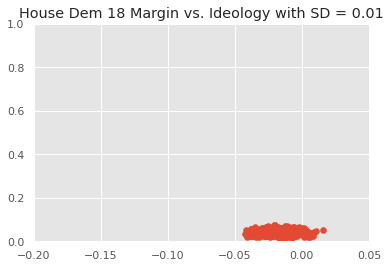

In [18]:
plt.scatter(df_a3["govtrack_ideology"], df_a3["house_dem18_margin"])
plt.xlim(-0.2, 0.05)
plt.ylim(0, 1)
plt.title("House Dem 18 Margin vs. Ideology with SD = 0.01");

**Part b** Using different variances produces very different scatterplots because the as the variance decreases, the prior for the Regressors are being picked from distributions more centered around the mean 0. As such, in the scatterplot with SD = 0.01, the coefficients are highly centered around 0, while in the scatterplot with SD = 1, the points are further from 0.

**Part c** A smaller sigma^2 value for the prior means we are assuming that how much Democrats won by in 2020 is not very dependent on how much they won by in 2018 and their ideologies.